# CARS recommender system
Implementation of the deep NN model described in the paper "Context-Aware Recommendations Based on Deep
Learning Frameworks".
https://dl.acm.org/doi/10.1145/3386243

Datasets:
- frappe


## Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split dataset in two parts
from sklearn.model_selection import KFold # to split dataset using  k-fold cross validation
from sklearn.metrics import * # evaluation metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt # for creating chart
import requests # for downloading the dataset
from collections import deque # queue data structure
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, leaves_list # for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering



### Some functions



In [ ]:
# plot loss based on history of model.fit, ymin and ymax are the minimum and maximum values of the y axis
def plot_loss(history, ymin=0, ymax=1):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim([ymin, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# plot chart of true values on predictions
def plot_predictions(test_y, pred_y):
  a = plt.axes(aspect='equal')
  plt.scatter(test_y, pred_y)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  lims = [0, 5]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

def sigmoid(x):
   return 1 / ( 1 + np.exp(-x))


## Dataset

### Load dataset

In [ ]:
# download the dataset
url = 'https://raw.githubusercontent.com/CriptHunter/tesi/master/CARS_DL/frappe/frappe.csv'
req = requests.get(url, allow_redirects=True)
open('frappe.csv', 'wb').write(req.content)

6313241

In [ ]:
# open the dataset
df = pd.read_csv('/content/frappe.csv', sep="\t")
df

,user,item,cnt,daytime,weekday,isweekend,homework,cost,weather,country,city
0,0,0,1,morning,sunday,weekend,unknown,free,sunny,United States,0
1,1,1,7,afternoon,saturday,weekend,unknown,free,cloudy,Spain,0
2,2,2,6,evening,monday,workday,unknown,free,cloudy,Spain,369
3,3,3,1,sunset,thursday,workday,unknown,free,unknown,United States,1028
4,4,4,428,night,thursday,workday,home,free,sunny,Switzerland,147
...,...,...,...,...,...,...,...,...,...,...,...
96198,110,0,5,evening,sunday,weekend,unknown,free,sunny,United States,0
96199,37,16,101,sunset,sunday,weekend,unknown,free,cloudy,Canada,128
96200,181,33,243,afternoon,sunday,weekend,unknown,free,cloudy,Israel,454
96201,451,752,1,evening,sunday,weekend,unknown,free,sunny,United States,0


In [ ]:
# count unique values for each column
display("------ unique values ------")
display(df.nunique())

# count number of unknown values for each column
display("------ unknown values ------")
display(df.isin(['unknown']).sum(axis=0))

# count number of zero values for each column (for city 0 == unknown)
display("------ zero values ------")
display(df.isin([0]).sum(axis=0))

'------ unique values ------'

user          957
item         4082
cnt          1981
daytime         7
weekday         7
isweekend       2
homework        3
cost            2
weather         9
country        80
city          233
dtype: int64

'------ unknown values ------'

user             0
item             0
cnt              0
daytime          0
weekday          0
isweekend        0
homework     75670
cost             0
weather      12529
country       7025
city             0
dtype: int64

'------ zero values ------'

user            25
item           521
cnt              0
daytime          0
weekday          0
isweekend        0
homework         0
cost             0
weather          0
country          0
city         38052
dtype: int64

### Dataset preprocessing

In [ ]:
# log transformation on the raw frequency numbers that represent the applications usage
df['cnt'] = df['cnt'].apply(np.log10)
f"frequency range is {df['cnt'][df['cnt'] == df['cnt'].min()].values[0]} to {df['cnt'][df['cnt'] == df['cnt'].max()].values[0]}"

# delete columns that are not needed
del df['homework']
del df['cost']
del df['city']
del df['isweekend']
del df['country']

In [ ]:
# delete rows where weather is unknown
df = df[df.weather != 'unknown']
df = df.reset_index(drop=True)

# make user and items id start from 0
df.user = pd.factorize(df.user)[0]
df.item = pd.factorize(df.item)[0]

df

,user,item,cnt,daytime,weekday,weather
0,0,0,0.000000,morning,sunday,sunny
1,1,1,0.845098,afternoon,saturday,cloudy
2,2,2,0.778151,evening,monday,cloudy
3,3,3,2.631444,night,thursday,sunny
4,4,4,0.778151,sunset,saturday,sunny
...,...,...,...,...,...,...
83669,96,0,0.698970,evening,sunday,sunny
83670,30,33,2.004321,sunset,sunday,cloudy
83671,156,26,2.385606,afternoon,sunday,cloudy
83672,399,672,0.000000,evening,sunday,sunny


In [ ]:
x_labels = ['user', 'item']
y_label = 'cnt'
context_labels = ['daytime', 'weekday', 'weather']

# convert categorical data to one-hot encoding
for col in context_labels:
  df = pd.get_dummies(df, columns=[col], prefix = [col])

# new context labels after one-hot encoding are columns from 3 to the end
context_labels = df.columns[3:]
df

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# k-fold cross validation object
kf = KFold(n_splits=3, random_state=42, shuffle=True)

def kfold_train(model, epochs, batch_size, verbose, df, x_labels, y_label, context_labels, kf):
    '''
    Train a model using K-fold CV

    Parameters:
        model: the model to be trained
        epochs: training epochs for each fold
        batch_size: batch size for each fold
        verbose: show training batch and loss
        df: the dataframe on which the model will be trained
        x_labels: features labels
        y_label: value to predict label
        context_labels: contextual features labels
        kf: sklearn kfold object
    '''
    idx = 0
    rmse = np.empty(kf.n_splits)
    mae = np.empty(kf.n_splits)

    for train_index, test_index in kf.split(df):
        print(f'Training on fold {idx}...')
        train_x = df.loc[train_index, x_labels]  # get a dataset subset with df.loc[rows, columns]
        train_y = df.loc[train_index, y_label]
        train_context = df.loc[train_index, context_labels]
        model.fit([train_x.user, train_x.item, train_context], train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

        print(f'Testing on fold {idx}...')
        test_x = df.loc[test_index, x_labels]
        test_y = df.loc[test_index, y_label]
        test_context = df.loc[test_index, context_labels]
        pred_y = model.predict([test_x.user, test_x.item, test_context]).flatten()
        rmse[idx] = mean_squared_error(test_y, pred_y, squared = False)
        mae[idx] = mean_absolute_error(test_y, pred_y)
        print(f'RMSE = {rmse[idx]}    MAE = {mae[idx]}')

        idx = idx + 1
    
    return np.mean(rmse), np.mean(mae)

In [ ]:
# count number of unique users and items
n_users, n_items = len(df.user.unique()), len(df.item.unique())
n_context = len(context_labels)

# embedding vectors length
n_latent_factors_user = 8
n_latent_factors_item = 12

f'Number of users: {n_users}      Number of apps: {n_items}     Number of context features: {n_context}'

'Number of users: 862      Number of apps: 3663     Number of context features: 22'

### Latent context extraction


In [ ]:
train_context_AE, test_context_AE = train_test_split(df.loc[:,context_labels], test_size=0.2)

In [ ]:
# size of the encoded representation
n_latent_context = 11

# input layer
input = Input(shape=(n_context,))
# the encoded representation of the input
encoded = Dense(n_latent_context, activation='sigmoid')(input)
# the reconstruction of the input
decoded = Dense(n_context, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = keras.Model(input, decoded)

# Only encoder model
encoder = keras.Model(input, encoded)

# Only Decoder model
encoded_input = keras.Input(shape=(n_latent_context,))   # takes as input the encoded context
decoder_layer = autoencoder.layers[-1]   # Retrieve the last layer of the autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# train the autoencoder on the context
history = autoencoder.fit(train_context_AE, train_context_AE,
                          epochs=50,
                          verbose=False,
                          batch_size=128,
                          validation_data=(test_context_AE, test_context_AE))

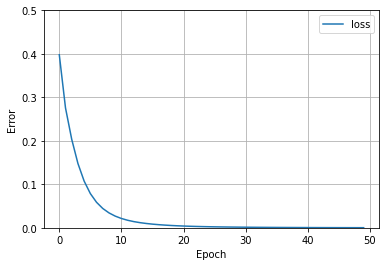

In [ ]:
plot_loss(history, ymin=0, ymax=0.5)

In [ ]:
# get weight matrix of neurons that connect input layers to hidden layer
# get weight returns a list of weights and biases, by taking weight[0] you extract only the weights
weight_matrix = autoencoder.layers[1].get_weights()[0]
weight_matrix = np.asarray(weight_matrix)

def get_latent_context():
    latent_context = np.empty(shape=(df.shape[0], n_latent_context))
    latent_context_labels = [f"latent_{x}" for x in range(n_latent_context)]
    
    # multiply each context sample for the weight matrix
    for idx, s in enumerate(df.loc[:, context_labels].values):
        latent_context[idx] = s @ weight_matrix
    
    # apply activation function
    latent_context = sigmoid(latent_context)
    df_latent_context = pd.DataFrame(latent_context, columns=latent_context_labels)

    return df_latent_context, latent_context_labels

df_latent_context, latent_context_labels = get_latent_context()
df = pd.concat([df, df_latent_context], axis=1)
df
        

,user,item,cnt,daytime_afternoon,daytime_evening,daytime_morning,daytime_night,daytime_noon,daytime_sunrise,daytime_sunset,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weather_cloudy,weather_drizzle,weather_foggy,weather_rainy,weather_sleet,weather_snowy,weather_stormy,weather_sunny,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,latent_11,latent_12,latent_13,latent_14,latent_15
0,0,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.000853,0.048048,0.735137,0.974135,0.446226,0.995238,0.769523,0.816098,0.096244,0.050986,0.187310,0.284346,0.907521,0.644151,0.286565,0.932570
1,1,1,0.845098,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.968693,0.871852,0.825121,0.528074,0.004117,0.646530,0.019732,0.002078,0.935121,0.773516,0.330553,0.346099,0.927414,0.839496,0.965619,0.986212
2,2,2,0.778151,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.978106,0.498408,0.051988,0.271581,0.579981,0.038571,0.560378,0.113247,0.924877,0.062711,0.989610,0.992742,0.715922,0.758525,0.873728,0.988430
3,3,3,2.631444,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.871938,0.916534,0.890909,0.960401,0.050406,0.986975,0.291505,0.988695,0.034046,0.977222,0.969672,0.082198,0.005099,0.643604,0.033241,0.916909
4,4,4,0.778151,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.603757,0.884427,0.090568,0.933266,0.041080,0.993404,0.010031,0.941918,0.993844,0.064222,0.302372,0.035510,0.465181,0.248359,0.294272,0.998199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83669,96,0,0.698970,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.006537,0.074824,0.066773,0.852115,0.993822,0.994701,0.126269,0.269756,0.591701,0.101148,0.949122,0.435942,0.240002,0.949649,0.119006,0.988220
83670,30,33,2.004321,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.009542,0.414753,0.002703,0.977947,0.158713,0.718440,0.012379,0.417549,0.268898,0.781625,0.984926,0.430041,0.992947,0.295088,0.766684,0.991360
83671,156,26,2.385606,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.031894,0.072258,0.492968,0.713750,0.107943,0.664600,0.054184,0.003529,0.178884,0.955006,0.956569,0.378154,0.993352,0.936117,0.805835,0.970666
83672,399,672,0.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.006537,0.074824,0.066773,0.852115,0.993822,0.994701,0.126269,0.269756,0.591701,0.101148,0.949122,0.435942,0.240002,0.949649,0.119006,0.988220


### Hierarchical context extraction

In [ ]:
def is_leaf(node):
    return node.left is None and node.right is None

# Recursive function to find paths from root node to every leaf node of a binary tree
def root_leaf_paths(node, path, hierarchy):

    if node is None:
        return
 
    path.append(node.id)
 
    if is_leaf(node):
        hierarchy.append(list(path)) # append a complete path to the list of all paths
 
    # Call the functions on left and right subtrees
    root_leaf_paths(node.left, path, hierarchy)
    root_leaf_paths(node.right, path, hierarchy)
 
    # remove current node after left and right subtrees are done
    path.pop()

def hierarchical_clustering(df):
    linked = linkage(df, 'ward')  # linkage matrix
    rootnode, nodelist = to_tree(linked, rd=True) # tree representing the hierarchical clustering
    path = deque() # a path from the root node to a leaf
    hierarchy = []
    root_leaf_paths(rootnode, path, hierarchy)
    hierarchy.sort(key=lambda x: x[-1]) # sort the list by the last element (datapoints id)
    return hierarchy

In [ ]:
# not enough RAM to do hierarchical clustering on all elements of the dataset
hier_context = hierarchical_clustering(df.loc[:10, latent_context_labels])
hier_context

[[20, 19, 17, 0],
 [20, 18, 16, 15, 12, 1],
 [20, 18, 2],
 [20, 19, 17, 13, 3],
 [20, 19, 14, 11, 4],
 [20, 18, 16, 5],
 [20, 19, 14, 6],
 [20, 18, 16, 15, 12, 7],
 [20, 19, 14, 11, 8],
 [20, 19, 17, 13, 9],
 [20, 18, 16, 15, 10]]

## Models

In [ ]:
# Dictionary that contain evaluation metrics for every model
models_eval_metrics = {}

### ECAM NCF

In [ ]:
def ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # Item embedding
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding')(item_input)
    item_vec_mlp = Flatten(name='flatten_item')(item_embedding_mlp)
    item_vec_mlp = Dropout(0.2)(item_vec_mlp)

    # User embedding
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding')(user_input)
    user_vec_mlp = Flatten(name='flatten_user')(user_embedding_mlp)
    user_vec_mlp = Dropout(0.2)(user_vec_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    batch_1 = BatchNormalization()(dense)
    dense_2 = Dense(4, name='fully_connected_2')(batch_1)
    batch_2 = BatchNormalization()(dense_2)
    dense_3 = Dense(2, name='fully_connected_3')(batch_2)

    # Output
    pred_mlp = Dense(1, activation='relu', name='Activation')(dense_3)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], pred_mlp)

In [ ]:
ecam_ncf = ncf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.005)
ecam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_ncf.summary()
#tf.keras.utils.plot_model(ecam_ncf)

In [ ]:
rmse, mae = kfold_train(ecam_ncf, 15, 128, False, df, x_labels, y_label, context_labels, kf)
models_eval_metrics['ecam_ncf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6928002656880194    MAE = 0.5228774076546783
Training on fold 1...
Testing on fold 1...
RMSE = 0.680449990262537    MAE = 0.5103500142766548
Training on fold 2...
Testing on fold 2...
RMSE = 0.6807666070349784    MAE = 0.5089839988482593


'k-fold RMSE = 0.684672287661845     k-fold MAE = 0.5140704735931975'

### ECAM NeuMF

In [ ]:
# latent factors for matrix factorization
n_latent_factors_mf = 10

In [ ]:
def neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf):
    # inputs
    item_input = Input(shape=[1],name='item')
    user_input = Input(shape=[1],name='user')
    context_input = Input(shape=(n_context, ), name='context')

    # item embedding MF
    item_embedding_mf = Embedding(n_items + 1, n_latent_factors_mf, name='item_embedding_MF')(item_input)
    item_vec_mf = Flatten(name='flatten_item_MF')(item_embedding_mf)
    item_vec_mf = Dropout(0.2)(item_vec_mf)

    # User embedding MF
    user_embedding_mf = Embedding(n_users + 1, n_latent_factors_mf,name='user_embedding_MF')(user_input)
    user_vec_mf = Flatten(name='flatten_user_MF')(user_embedding_mf)
    user_vec_mf = Dropout(0.2)(user_vec_mf)

    # Dot product MF
    dot = tf.keras.layers.Dot(axes=1)([user_vec_mf, item_vec_mf])

    # Item embedding MLP
    item_embedding_mlp = Embedding(n_items + 1, n_latent_factors_item, name='item_embedding_MLP')(item_input)
    item_vec_mlp = Flatten(name='flatten_item_MLP')(item_embedding_mlp)
    item_vec_mlp = Dropout(0.2)(item_vec_mlp)

    # User embedding MLP
    user_embedding_mlp = Embedding(n_users + 1, n_latent_factors_user,name='user_embedding_MLP')(user_input)
    user_vec_mlp = Flatten(name='flatten_user_MLP')(user_embedding_mlp)
    user_vec_mlp = Dropout(0.2)(user_vec_mlp)

    # Concat user embedding,item embeddings and context vector
    concat = Concatenate(name='user_item_context_MLP')([item_vec_mlp, user_vec_mlp, context_input])

    # dense layers
    dense = Dense(8, name='fully_connected_1')(concat)
    batch_1 = BatchNormalization()(dense)
    dense_2 = Dense(4, name='fully_connected_2')(batch_1)
    batch_2 = BatchNormalization()(dense_2)
    dense_3 = Dense(2, name='fully_connected_3')(batch_2)

    # concat MF and MLP
    concat_mf_mlp = Concatenate(name='MF_MLP')([dense_3, dot])

    # Output
    output = Dense(1, activation='relu',name='Activation')(concat_mf_mlp)

    # make and build the model
    return keras.Model([user_input, item_input, context_input], output)

In [ ]:
ecam_neumf = neumf(n_users, n_items, n_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.005)
ecam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ecam_neumf.summary()
#tf.keras.utils.plot_model(ecam_neumf)

In [ ]:
rmse, mae = kfold_train(ecam_neumf, 15, 128, False, df, x_labels, y_label, context_labels, kf)
models_eval_metrics['ecam_neumf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6411023517255005    MAE = 0.47827594811513535
Training on fold 1...
Testing on fold 1...
RMSE = 0.6200889344701865    MAE = 0.45548439708226995
Training on fold 2...
Testing on fold 2...
RMSE = 0.6152474588112614    MAE = 0.4516791726818998


'k-fold RMSE = 0.6254795816689828     k-fold MAE = 0.461813172626435'

### UCAM NCF

In [ ]:
ucam_ncf = ncf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item)
opt = keras.optimizers.Adam(lr = 0.005)
ucam_ncf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

#ucam_ncf.summary()
#tf.keras.utils.plot_model(ucam_ncf)

In [ ]:
rmse, mae = kfold_train(ucam_ncf, 15, 128, False, df, x_labels, y_label, latent_context_labels, kf)
models_eval_metrics['ucam_ncf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6914577848666951    MAE = 0.5229821682879126
Training on fold 1...
Testing on fold 1...
RMSE = 0.683436925962301    MAE = 0.5116804156872785
Training on fold 2...
Testing on fold 2...
RMSE = 0.6814041027873317    MAE = 0.5103031410100066


'k-fold RMSE = 0.6854329378721092     k-fold MAE = 0.5149885749950659'

### UCAM NeuMF

In [ ]:
ucam_neumf = neumf(n_users, n_items, n_latent_context, n_latent_factors_user, n_latent_factors_item, n_latent_factors_mf)
opt = keras.optimizers.Adam(lr = 0.005)
ucam_neumf.compile(optimizer = opt,loss= 'mean_absolute_error', metrics=['mae', 'mse'])

In [ ]:
rmse, mae = kfold_train(ucam_neumf, 15, 128, False, df, x_labels, y_label, latent_context_labels, kf)
models_eval_metrics['ucam_neumf'] = [rmse, mae]
f'k-fold RMSE = {rmse}     k-fold MAE = {mae}'

Training on fold 0...
Testing on fold 0...
RMSE = 0.6447765768049659    MAE = 0.4796744632567538
Training on fold 1...
Testing on fold 1...
RMSE = 0.6204256891410276    MAE = 0.45723662526967057
Training on fold 2...
Testing on fold 2...
RMSE = 0.6182982763037207    MAE = 0.45452376387690935


'k-fold RMSE = 0.6278335140832381     k-fold MAE = 0.46381161746777794'

### Performance comparison

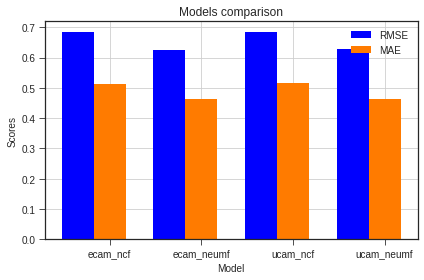

Name: ecam_ncf    	    MAE: 0.684672287661845    	    RMSE: 0.5140704735931975
Name: ecam_neumf    	    MAE: 0.6254795816689828    	    RMSE: 0.461813172626435
Name: ucam_ncf    	    MAE: 0.6854329378721092    	    RMSE: 0.5149885749950659
Name: ucam_neumf    	    MAE: 0.6278335140832381    	    RMSE: 0.46381161746777794


In [ ]:
n_models = 4 # number of different models
models_name = [x[0] for x in models_eval_metrics.items()] 
mae = [x[0] for x in models_eval_metrics.values()]
rmse = [x[1] for x in models_eval_metrics.values()]

fig, ax = plt.subplots()
index = np.arange(n_models)
bar_width = 0.35

# MAE bar
rect1 = plt.bar(index, mae, bar_width,
color='b',
label='RMSE')

# RMSE bar
rect2 = plt.bar(index + bar_width, rmse, bar_width,
color='#ff7b00',
label='MAE')

plt.style.use('seaborn-ticks') # readable chart on dark editor
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Models comparison')
plt.xticks(index + bar_width, models_name)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for name, mae, rmse in zip(models_name, mae, rmse):
    print(f"Name: {name}    \t    MAE: {mae}    \t    RMSE: {rmse}")